In [ ]:
#cheatsheet 1

#!/usr/bin/env python
# coding: utf-8

# In[1]:


## Print multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


# In[2]:


## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()


# In[3]:


## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)


# ## Read data

# In[4]:


## Reading relevant data
match_lvl_data = pd.read_csv('/content/667a9888c9104_match_level_scorecard.csv')
match_df = pd.read_csv('/content/667a9888c9104_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/content/667a985a7541a_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/content/667a98513f849_bowler_level_scorecard.csv')
batsman_df = pd.read_csv('/content/667a985a7541a_batsman_level_scorecard.csv')
bowler_df = pd.read_csv('/content/667a98513f849_bowler_level_scorecard.csv')
train_data = pd.read_csv('/content/train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/content/667a986f0b981_r2_data_with_samplefeatures.csv')

## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

train_data['winner_01'] = train_data.apply(lambda x: 1 if (x['team2']==x['winner']) else 0, axis=1)

## Toss winner to numerical - 1 if team2 wins, else 0

train_data['toss_winner_01'] = np.where(train_data['toss winner']==train_data['team2'], 1, 0)
test_data['toss_winner_01'] = np.where(test_data['toss winner']==test_data['team2'], 1, 0)

## Toss decision - categorical - 1 if winner bats, 0 otherwise

train_data['toss_decision_01'] = np.where(train_data['toss decision']=='bat', 1, 0)
test_data['toss_decision_01'] = np.where(test_data['toss decision']=='bat', 1, 0)

#Defines the giveLastNgamesPlayer function to get the last n games stats of a player before an input date.
#The function takes parameters: player ID (player_id), date to look back (date), number of games (n), and whether to return batting or bowling stats (bat_or_bowl).
#The function returns a dataframe with the requested stats, sorted by date.

def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
               .sort_values(by='match_dt', ascending=False).head(n)
    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==player_id)]\
                .sort_values(by='match_dt', ascending=False).head(n)

# ## Code to plot RnP
# Code to plot value of that feature and different bins and percentage winning at each bin

# In[11]:


from matplotlib import pyplot as plt
plt.style.use('seaborn');
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.

    Parameters-
    1. X_12: dataset to build the RnP on.
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.

    Output-
    1. Rank and Plot

    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();


<ipython-input-2-d62cf2144283>:100: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn');


100%|██████████| 207/207 [00:00<00:00, 231.83it/s]


   team1_top5_batsmen_ratio  team2_top5_batsmen_ratio  top5_batsmen_ratio
0  1.000000                  1.000000                  1.000000          
1  0.830243                  0.730874                  1.135958          
2  0.606225                  0.826870                  0.733156          
3  0.762315                  0.762840                  0.999312          
4  0.818646                  0.933333                  0.877121          
   team1_top5_batsmen_ratio  team2_top5_batsmen_ratio  top5_batsmen_ratio
0  0.850433                  0.839713                  1.012766          
1  0.756522                  0.755525                  1.001319          
2  0.823455                  0.850457                  0.968251          
3  0.679487                  0.816770                  0.831920          
4  0.653409                  0.773157                  0.845118          
slope: 0.6 / 0.44 =  1.36


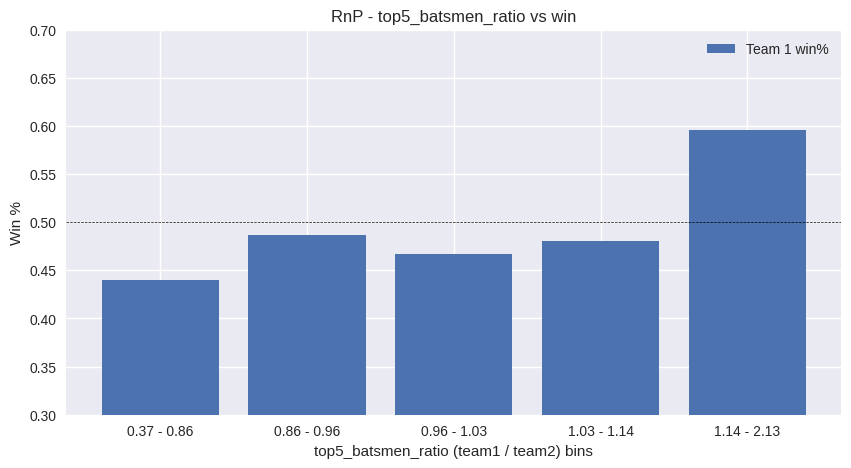

In [ ]:
#top 5 batsman runs scored
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

# Load the datasets
batsman_df = batsman_lvl_data
bowler_df = bowler_lvl_data
match_df = match_lvl_data


# Helper function to identify team for a batsman
def get_team_id(batsman_id, match_id):
    match_row = match_df[match_df['match id'] == match_id]
    if match_row.empty:
        return np.nan
    team1_roster = match_row['team1_roster_ids'].values[0].split(':')
    team2_roster = match_row['team2_roster_ids'].values[0].split(':')
    if str(batsman_id) in team1_roster:
        return match_row['team1_id'].values[0]
    elif str(batsman_id) in team2_roster:
        return match_row['team2_id'].values[0]
    else:
        return np.nan

# Apply the helper function to add team_id to batsman_df
batsman_df['team_id'] = batsman_df.apply(lambda x: get_team_id(x['batsman_id'], x['match id']), axis=1)

# Helper function to calculate the ratio of runs scored by the first 5 batsmen
def calculate_top5_batsmen_ratio(team_id, date, n=5):
    relevant_matches = match_df[(match_df['match_dt'] < date) &
                                ((match_df['team1_id'] == team_id) | (match_df['team2_id'] == team_id))]\
                                .sort_values(by='match_dt', ascending=False).head(n)
    match_ids = relevant_matches['match id'].unique()
    team_batsmen = batsman_df[(batsman_df['match id'].isin(match_ids)) & (batsman_df['team_id'] == team_id)]

    if team_batsmen.empty:
        return np.nan

    top5_batsmen = team_batsmen.sort_values(by='over_faced_first').groupby('match id').head(5)
    total_runs_top5 = top5_batsmen['runs'].sum()
    total_runs_team = team_batsmen['runs'].sum()

    return total_runs_top5 / total_runs_team if total_runs_team > 0 else np.nan

# Calculate the ratio for both teams in training data
train_data['team1_top5_batsmen_ratio'] = train_data.progress_apply(lambda x: calculate_top5_batsmen_ratio(x['team1_id'], x['match_dt']), axis=1)
train_data['team2_top5_batsmen_ratio'] = train_data.progress_apply(lambda x: calculate_top5_batsmen_ratio(x['team2_id'], x['match_dt']), axis=1)

# Calculate the ratio for both teams in test data
test_data['team1_top5_batsmen_ratio'] = test_data.progress_apply(lambda x: calculate_top5_batsmen_ratio(x['team1_id'], x['match_dt']), axis=1)
test_data['team2_top5_batsmen_ratio'] = test_data.progress_apply(lambda x: calculate_top5_batsmen_ratio(x['team2_id'], x['match_dt']), axis=1)

# Calculate the final feature as the ratio of team 1's top 5 batsmen ratio to team 2's top 5 batsmen ratio
train_data['top5_batsmen_ratio'] = train_data['team1_top5_batsmen_ratio'] / train_data['team2_top5_batsmen_ratio']
test_data['top5_batsmen_ratio'] = test_data['team1_top5_batsmen_ratio'] / test_data['team2_top5_batsmen_ratio']

# Inspect the new features
print(train_data[['team1_top5_batsmen_ratio', 'team2_top5_batsmen_ratio', 'top5_batsmen_ratio']].head())
print(test_data[['team1_top5_batsmen_ratio', 'team2_top5_batsmen_ratio', 'top5_batsmen_ratio']].head())

createRnP(train_data , 'top5_batsmen_ratio')

100%|██████████| 207/207 [00:00<00:00, 356.16it/s]


slope: 0.57 / 0.43 =  1.31


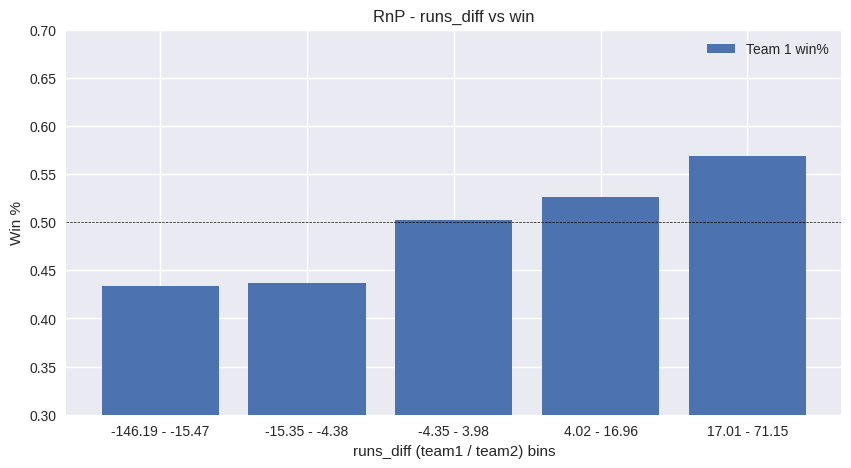

In [ ]:
#difference of the expected runs scored by both the teams
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()


# Helper function to determine team for a player based on roster IDs
def get_team_id(player_id, match_id):
    match_row = match_df[match_df['match id'] == match_id].iloc[0]
    team1_roster = match_row['team1_roster_ids'].split(':')
    team2_roster = match_row['team2_roster_ids'].split(':')
    if str(player_id) in team1_roster:
        return match_row['team1_id']
    elif str(player_id) in team2_roster:
        return match_row['team2_id']
    return np.nan

# Apply team_id to batsman and bowler dataframes
batsman_df['team_id'] = batsman_df.apply(lambda x: get_team_id(x['batsman_id'], x['match id']), axis=1)
bowler_df['team_id'] = bowler_df.apply(lambda x: get_team_id(x['bowler_id'], x['match id']), axis=1)

# Helper function to calculate batting average (x)
def calculate_batting_average(team_id, date, n=5):
    relevant_matches = match_df[(match_df['match_dt'] < date) &
                                ((match_df['team1_id'] == team_id) | (match_df['team2_id'] == team_id))]\
                                .sort_values(by='match_dt', ascending=False).head(n)
    match_ids = relevant_matches['match id'].unique()
    team_batsmen = batsman_df[(batsman_df['match id'].isin(match_ids)) & (batsman_df['team_id'] == team_id)]
    total_runs = team_batsmen['runs'].sum()
    total_balls_faced = team_batsmen['balls_faced'].sum()
    return total_runs / total_balls_faced if total_balls_faced > 0 else np.nan

# Helper function to calculate bowling average (y)
def calculate_bowling_average(team_id, date, n=5):
    relevant_matches = match_df[(match_df['match_dt'] < date) &
                                ((match_df['team1_id'] == team_id) | (match_df['team2_id'] == team_id))]\
                                .sort_values(by='match_dt', ascending=False).head(n)
    match_ids = relevant_matches['match id'].unique()
    team_bowlers = bowler_df[(bowler_df['match id'].isin(match_ids)) & (bowler_df['team_id'] == team_id)]
    total_wickets = team_bowlers['wicket_count'].sum()
    total_balls_bowled = team_bowlers['balls_bowled'].sum()
    return total_wickets / total_balls_bowled if total_balls_bowled > 0 else np.nan

# Calculate the batting and bowling averages for both teams in training data
train_data['team1_batting_average'] = train_data.progress_apply(lambda x: calculate_batting_average(x['team1_id'], x['match_dt']), axis=1)
train_data['team2_batting_average'] = train_data.progress_apply(lambda x: calculate_batting_average(x['team2_id'], x['match_dt']), axis=1)

train_data['team1_bowling_average'] = train_data.progress_apply(lambda x: calculate_bowling_average(x['team1_id'], x['match_dt']), axis=1)
train_data['team2_bowling_average'] = train_data.progress_apply(lambda x: calculate_bowling_average(x['team2_id'], x['match_dt']), axis=1)

# Calculate the batting and bowling averages for both teams in test data
test_data['team1_batting_average'] = test_data.progress_apply(lambda x: calculate_batting_average(x['team1_id'], x['match_dt']), axis=1)
test_data['team2_batting_average'] = test_data.progress_apply(lambda x: calculate_batting_average(x['team2_id'], x['match_dt']), axis=1)

test_data['team1_bowling_average'] = test_data.progress_apply(lambda x: calculate_bowling_average(x['team1_id'], x['match_dt']), axis=1)
test_data['team2_bowling_average'] = test_data.progress_apply(lambda x: calculate_bowling_average(x['team2_id'], x['match_dt']), axis=1)

# Helper function to calculate B
def calculate_B(y):
    return 10 / y if y > (1 / 12) else 120

# Calculate B for both teams in training data
train_data['team1_balls_faced'] = train_data['team1_bowling_average'].apply(calculate_B)
train_data['team2_balls_faced'] = train_data['team2_bowling_average'].apply(calculate_B)

# Calculate B for both teams in test data
test_data['team1_balls_faced'] = test_data['team1_bowling_average'].apply(calculate_B)
test_data['team2_balls_faced'] = test_data['team2_bowling_average'].apply(calculate_B)

# Calculate R as x * B for both teams
train_data['team1_runs_scored'] = train_data['team1_batting_average'] * train_data['team1_balls_faced']
train_data['team2_runs_scored'] = train_data['team2_batting_average'] * train_data['team2_balls_faced']

test_data['team1_runs_scored'] = test_data['team1_batting_average'] * test_data['team1_balls_faced']
test_data['team2_runs_scored'] = test_data['team2_batting_average'] * test_data['team2_balls_faced']

# Calculate the final feature as the ratio of runs scored by team 1 to runs scored by team 2
train_data['runs_ratio'] = train_data['team1_runs_scored'] / train_data['team2_runs_scored']
test_data['runs_ratio'] = test_data['team1_runs_scored'] / test_data['team2_runs_scored']

# Calculate runs_diff with the condition
train_data['runs_diff'] = train_data.apply(lambda x: x['team1_runs_scored'] - x['team2_runs_scored'] if not np.isnan(x['team1_runs_scored']) and not np.isnan(x['team2_runs_scored']) else 0, axis=1)
test_data['runs_diff'] = test_data.apply(lambda x: x['team1_runs_scored'] - x['team2_runs_scored'] if not np.isnan(x['team1_runs_scored']) and not np.isnan(x['team2_runs_scored']) else 0, axis=1)

# Assuming createRnP is defined elsewhere in the code
createRnP(train_data, 'runs_diff')

In [ ]:
# Helper function to determine the team batting first
def get_batting_team(row):
    if (row['toss_winner_01'] == 1 and row['toss_decision_01'] == 1) or (row['toss_winner_01'] == 0 and row['toss_decision_01'] == 0):
        return row['team2_id']  # Team 2 is batting first
    else:
        return row['team1_id']  # Team 1 is batting first

# Add the batting first team column
train_data['batting_first_team'] = train_data.progress_apply(get_batting_team, axis=1)
test_data['batting_first_team'] = test_data.progress_apply(get_batting_team, axis=1)

# Helper function to calculate the win percentage for the batting first team on a specific ground
def win_percentage_batting_first_ground(team_id, date, ground_id):
    relevant_matches = match_df[(match_df['match_dt'] < date) & (match_df['ground_id'] == ground_id)].head(5)
    total_matches = relevant_matches.shape[0]
    wins = relevant_matches[(relevant_matches['winner_id'] == team_id) &
                            (((relevant_matches['toss winner'] == team_id) & (relevant_matches['toss decision'] == 'bat')) |
                             ((relevant_matches['toss winner'] != team_id) & (relevant_matches['toss decision'] == 'field')))].shape[0]
    return wins / total_matches if total_matches > 0 else 0.5

# Helper function to calculate the win percentage for the batting second team on a specific ground
def win_percentage_batting_second_ground(team_id, date, ground_id):
    relevant_matches = match_df[(match_df['match_dt'] < date) & (match_df['ground_id'] == ground_id)].head(5)
    total_matches = relevant_matches.shape[0]
    wins = relevant_matches[(relevant_matches['winner_id'] == team_id) &
                            (((relevant_matches['toss winner'] == team_id) & (relevant_matches['toss decision'] == 'field')) |
                             ((relevant_matches['toss winner'] != team_id) & (relevant_matches['toss decision'] == 'bat')))].shape[0]
    return wins / total_matches if total_matches > 0 else 0.5

# Calculate the win percentage for the batting first and batting second team on the specific ground
train_data['win_percentage_batting_first_ground'] = train_data.progress_apply(
    lambda x: win_percentage_batting_first_ground(x['batting_first_team'], x['match_dt'], x['ground_id']), axis=1
)
train_data['win_percentage_batting_second_ground'] = train_data.progress_apply(
    lambda x: win_percentage_batting_second_ground(x['batting_first_team'], x['match_dt'], x['ground_id']), axis=1
)

test_data['win_percentage_batting_first_ground'] = test_data.progress_apply(
    lambda x: win_percentage_batting_first_ground(x['batting_first_team'], x['match_dt'], x['ground_id']), axis=1
)
test_data['win_percentage_batting_second_ground'] = test_data.progress_apply(
    lambda x: win_percentage_batting_second_ground(x['batting_first_team'], x['match_dt'], x['ground_id']), axis=1
)

# Combine the win percentages based on which team is batting first
def weighted_win_percentage(row):
    if row['batting_first_team'] == row['team1_id']:
        return row['win_percentage_batting_first_ground']
    else:
        return row['win_percentage_batting_second_ground']

train_data['round_weighted_win_percentage'] = train_data.progress_apply(weighted_win_percentage, axis=1)
test_data['round_weighted_win_percentage'] = test_data.progress_apply(weighted_win_percentage, axis=1)

# Helper function to find the last 5 matches where the team batted first and calculate the win percentage
def get_team_win_percentage_batting_first(team_id, match_df):
    relevant_matches = match_df[((match_df['team1_id'] == team_id) & (match_df['team1'] == match_df['toss winner'] ) & (match_df['toss decision'] == 'bat')) |
                                ((match_df['team1_id'] == team_id) & (match_df['team1'] != match_df['toss winner'] ) & (match_df['toss decision'] == 'field')) |
                                ((match_df['team2_id'] == team_id) & (match_df['team2'] == match_df['toss winner'] ) & (match_df['toss decision'] == 'bat')) |
                                ((match_df['team2_id'] == team_id) & (match_df['team2'] != match_df['toss winner'] ) & (match_df['toss decision'] == 'field')) ]
    relevant_matches = relevant_matches.sort_values(by='match_dt', ascending=False).head(10)
    total_matches = relevant_matches.shape[0]
    wins = relevant_matches[relevant_matches['winner_id'] == team_id].shape[0]
    return wins / total_matches if total_matches > 0 else 0.5

# Helper function to find the last 5 matches where the team bowled first and calculate the win percentage
def get_team_win_percentage_bowling_first(team_id, match_df):
    relevant_matches = match_df[((match_df['team1_id'] == team_id) & (match_df['team1'] != match_df['toss winner'] ) & (match_df['toss decision'] == 'bat')) |
                                ((match_df['team1_id'] == team_id) & (match_df['team1'] == match_df['toss winner'] ) & (match_df['toss decision'] == 'field')) |
                                ((match_df['team2_id'] == team_id) & (match_df['team2'] != match_df['toss winner'] ) & (match_df['toss decision'] == 'bat')) |
                                ((match_df['team2_id'] == team_id) & (match_df['team2'] == match_df['toss winner'] ) & (match_df['toss decision'] == 'field')) ]
    relevant_matches = relevant_matches.sort_values(by='match_dt', ascending=False).head(10)
    total_matches = relevant_matches.shape[0]
    wins = relevant_matches[relevant_matches['winner_id'] == team_id].shape[0]
    return wins / total_matches if total_matches > 0 else 0.5

# Add the batting first team column
train_data['batting_first_team'] = train_data.progress_apply(get_batting_team, axis=1)
test_data['batting_first_team'] = test_data.progress_apply(get_batting_team, axis=1)

# Calculate the win percentages for team1 and team2
train_data['team1_win_batting_first'] = train_data.apply(lambda x: get_team_win_percentage_batting_first(x['team1_id'], match_df), axis=1)
train_data['team1_win_bowling_first'] = train_data.apply(lambda x: get_team_win_percentage_bowling_first(x['team1_id'], match_df), axis=1)
train_data['team2_win_batting_first'] = train_data.apply(lambda x: get_team_win_percentage_batting_first(x['team2_id'], match_df), axis=1)
train_data['team2_win_bowling_first'] = train_data.apply(lambda x: get_team_win_percentage_bowling_first(x['team2_id'], match_df), axis=1)

test_data['team1_win_batting_first'] = test_data.apply(lambda x: get_team_win_percentage_batting_first(x['team1_id'], match_df), axis=1)
test_data['team1_win_bowling_first'] = test_data.apply(lambda x: get_team_win_percentage_bowling_first(x['team1_id'], match_df), axis=1)
test_data['team2_win_batting_first'] = test_data.apply(lambda x: get_team_win_percentage_batting_first(x['team2_id'], match_df), axis=1)
test_data['team2_win_bowling_first'] = test_data.apply(lambda x: get_team_win_percentage_bowling_first(x['team2_id'], match_df), axis=1)

# Adjust the ground_weighted_win_percentage based on the team batting or bowling first
def adjusted_weighted_win_percentage(row):
    if row['batting_first_team'] == row['team1_id']:
        return row['round_weighted_win_percentage'] * (row['team1_win_batting_first'] + 1) / (row['team2_win_bowling_first'] + 1)
    else:
        return row['round_weighted_win_percentage'] * (row['team1_win_bowling_first'] + 1) / (row['team2_win_batting_first'] + 1)

train_data['ground_weighted_win_percentage'] = train_data.progress_apply(adjusted_weighted_win_percentage, axis=1)
test_data['ground_weighted_win_percentage'] = test_data.progress_apply(adjusted_weighted_win_percentage, axis=1)

# Inspect the new feature
print(train_data[['batting_first_team', 'ground_id', 'win_percentage_batting_first_ground', 'win_percentage_batting_second_ground', 'ground_weighted_win_percentage']].head())
print(test_data[['batting_first_team', 'ground_id', 'win_percentage_batting_first_ground', 'win_percentage_batting_second_ground', 'ground_weighted_win_percentage']].head())

# Assuming createRnP is defined elsewhere in the code
createRnP(train_data, 'ground_weighted_win_percentage', N=10)


100%|██████████| 207/207 [00:00<00:00, 34350.98it/s]


KeyError: "['adjusted_ground_weighted_win_percentage'] not in index"

  0%|          | 0/948 [00:00<?, ?it/s]<ipython-input-7-5676322265f2>:21: RuntimeWarning: invalid value encountered in scalar divide
  if (total_runs/ matches) > 11 and (total_balls_bowled / matches) > 11 and matches > 0:
100%|██████████| 948/948 [01:15<00:00, 12.58it/s]


                                                                                                         team1_roster_ids  ... all_rounder_ratio
0  9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0  ...  1.000000        
1  2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0              ...  0.400000        
2  3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0           ...  1.333333        
3  8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0            ...  1.500000        
4  8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0  ...  1.000000        

[5 rows x 3 columns]


  0%|          | 0/207 [00:00<?, ?it/s]<ipython-input-7-5676322265f2>:21: RuntimeWarning: invalid value encountered in scalar divide
  if (total_runs/ matches) > 11 and (total_balls_bowled / matches) > 11 and matches > 0:
100%|██████████| 207/207 [00:17<00:00, 11.78it/s]


                                                                                                team1_roster_ids  ... all_rounder_ratio
0  4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0  ...  0.5             
1  5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0  ...  1.0             
2  5164844.0:8110185.0:2979857.0:1722048.0:2707431.0:3834361.0:2336487.0:5161652.0:3212292.0:8339701.0:5192830.0  ...  1.0             
3  3496933.0:4167673.0:4160316.0:1863889.0:310883.0:2667244.0:2294837.0:4239794.0:3802378.0:4168086.0:4817014.0   ...  1.0             
4  4166882.0:3009215.0:1963443.0:3252927.0:4171859.0:3009334.0:6665462.0:4875086.0:2295642.0:6845950.0:6816718.0  ...  1.0             

[5 rows x 3 columns]
slope: 0.48 / 0.4 =  1.22


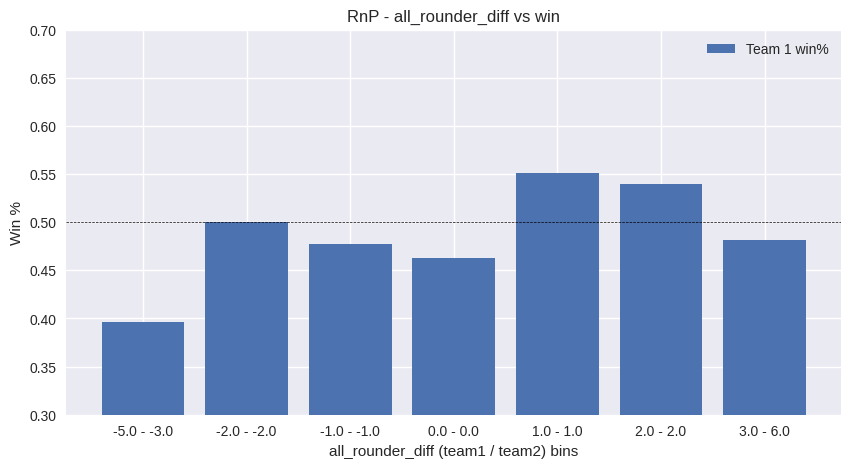

slope: 0.53 / 0.44 =  1.21


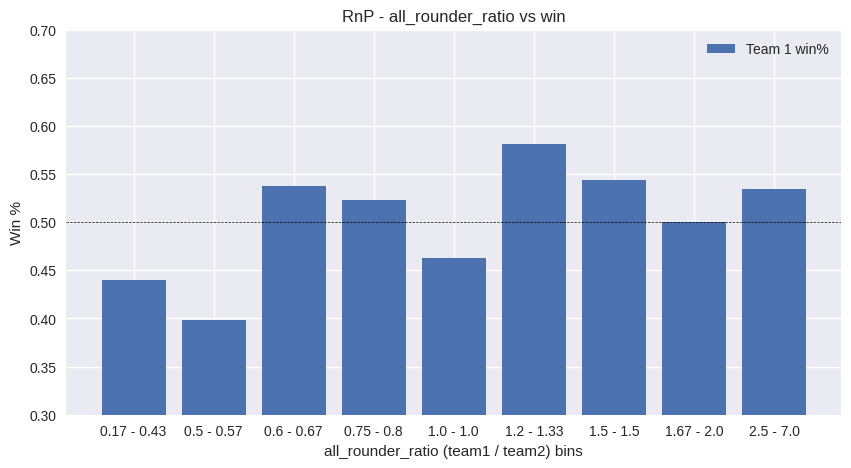

In [ ]:
#allrounder ratio and difference
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

# Assuming the datasets are already loaded into these dataframes:
# batsman_df, bowler_df, match_df, train_data, test_data

# Helper function to check if a player is an all-rounder
def is_all_rounder(player_id, date, n=15):
    batsman_stats = batsman_df[(batsman_df['batsman_id'] == player_id) & (batsman_df['match_dt'] < date)] \
                                .sort_values(by='match_dt', ascending=False).head(n)
    bowler_stats = bowler_df[(bowler_df['bowler_id'] == player_id) & (bowler_df['match_dt'] < date)] \
                                .sort_values(by='match_dt', ascending=False).head(n)

    total_runs = batsman_stats['runs'].sum()
    total_balls_bowled = bowler_stats['balls_bowled'].sum()
    matches = max(len(batsman_stats), len(bowler_stats))

    if (total_runs/ matches) > 11 and (total_balls_bowled / matches) > 11 and matches > 0:
        return True
    return False

# Helper function to count all-rounders in a team
def count_all_rounders(team_roster, date):
    all_rounder_count = 0
    for player_id in team_roster:
        if is_all_rounder(player_id, date):
            all_rounder_count += 1
    return all_rounder_count

# Helper function to convert roster IDs from string to list of integers
def convert_roster_ids(roster_ids):
    return [int(float(id_str)) for id_str in roster_ids.split(':')]

# Apply the conversion to calculate the number of all-rounders without modifying the original dataset
train_team1_all_rounders = train_data.progress_apply(lambda x: count_all_rounders(convert_roster_ids(x['team1_roster_ids']), x['match_dt']), axis=1)
train_team2_all_rounders = train_data.progress_apply(lambda x: count_all_rounders(convert_roster_ids(x['team2_roster_ids']), x['match_dt']), axis=1)

# Calculate the ratio of all-rounders
train_data['all_rounder_ratio'] = (train_team1_all_rounders + 1)/(train_team2_all_rounders + 1)

# Inspect the updated DataFrame
print(train_data[['team1_roster_ids', 'team2_roster_ids', 'all_rounder_ratio']].head())

train_data['all_rounder_diff'] = train_team1_all_rounders - train_team2_all_rounders

# Apply the conversion to calculate the number of all-rounders without modifying the original dataset
test_team1_all_rounders = test_data.progress_apply(lambda x: count_all_rounders(convert_roster_ids(x['team1_roster_ids']), x['match_dt']), axis=1)
test_team2_all_rounders = test_data.progress_apply(lambda x: count_all_rounders(convert_roster_ids(x['team2_roster_ids']), x['match_dt']), axis=1)

# Calculate the ratio of all-rounders
test_data['all_rounder_ratio'] = (test_team1_all_rounders + 1) / (test_team2_all_rounders + 1 )

# Inspect the updated DataFrame
print(test_data[['team1_roster_ids', 'team2_roster_ids', 'all_rounder_ratio']].head())

test_data['all_rounder_diff'] = test_team1_all_rounders - test_team2_all_rounders

createRnP(train_data, 'all_rounder_diff' , N = 10)
createRnP(train_data, 'all_rounder_ratio' , N = 10)

100%|██████████| 948/948 [00:03<00:00, 311.26it/s]


         x1        x2        y1        y2  toss_factor_win_percentage
0  0.600000  1.000000  0.538462  0.555556  0.538462                  
1  0.500000  0.400000  0.700000  0.461538  1.750000                  
2  0.500000  0.350000  0.363636  0.592593  1.038961                  
3  0.461538  0.428571  0.714286  0.600000  0.769231                  
4  0.428571  0.571429  0.500000  0.833333  0.875000                  
slope: 0.58 / 0.38 =  1.53


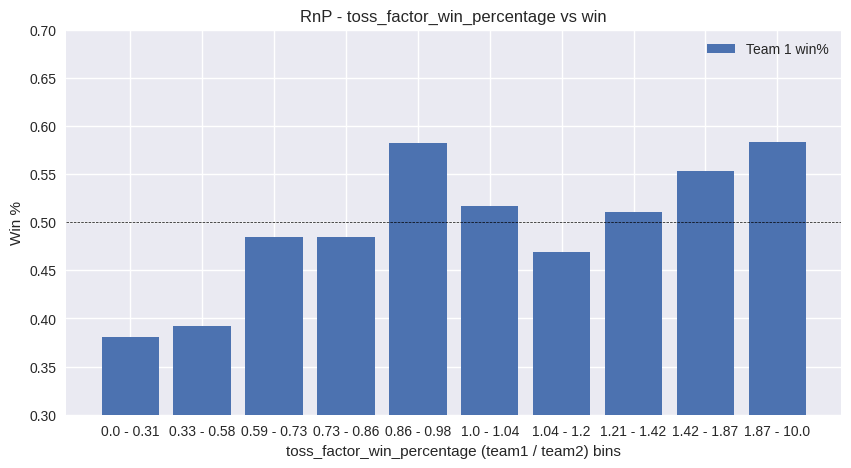

100%|██████████| 207/207 [00:00<00:00, 220.35it/s]

     x1        x2        y1        y2  toss_factor_win_percentage
0  0.20  0.400000  0.562500  0.416667  1.406250                  
1  0.80  0.473684  0.000000  0.384615  0.000000                  
2  0.50  0.700000  0.214286  0.647059  0.306122                  
3  0.00  0.750000  1.000000  1.000000  0.000000                  
4  0.25  1.000000  1.000000  0.250000  1.000000                  


In [ ]:
#team winning after toss win percentage feature
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

# Assuming the datasets are already loaded into these dataframes:
# batsman_df, bowler_df, match_df, train_data, test_data

# Define the helper functions
def toss_win_percentage(team, date):
    toss_wins = match_df[(match_df['toss winner'] == team) & (match_df['match_dt'] < date)].shape[0]
    total_matches = match_df[((match_df['team1'] == team) | (match_df['team2'] == team)) & (match_df['match_dt'] < date)].shape[0]
    return toss_wins / total_matches if total_matches > 0 else 0

def win_percentage_after_toss(team_id, date):
    wins = match_df[(match_df['toss winner'] == team_id) & (match_df['winner'] == team_id) & (match_df['match_dt'] < date)].shape[0]
    toss_wins = match_df[(match_df['toss winner'] == team_id) & (match_df['match_dt'] < date)].shape[0]
    return wins / toss_wins if toss_wins > 0 else 0

def win_percentage_after_losing_toss(team_id, date):
    losses = match_df[(match_df['toss winner'] != team_id) & (match_df['winner'] == team_id) & (match_df['match_dt'] < date)].shape[0]
    toss_losses = match_df[(match_df['toss winner'] != team_id) & ((match_df['team1'] == team_id) | (match_df['team2'] == team_id)) & (match_df['match_dt'] < date)].shape[0]
    return losses / toss_losses if toss_losses > 0 else 0

# Calculate the percentages for both teams in training data
train_data['team1_toss_win_percentage'] = train_data.progress_apply(lambda x: toss_win_percentage(x['team1'], x['match_dt']), axis=1)
train_data['team2_toss_win_percentage'] = train_data.progress_apply(lambda x: toss_win_percentage(x['team2'], x['match_dt']), axis=1)

train_data['team1_win_percentage_after_winning_toss'] = train_data.progress_apply(lambda x: win_percentage_after_toss(x['team1'], x['match_dt']), axis=1)
train_data['team2_win_percentage_after_winning_toss'] = train_data.progress_apply(lambda x: win_percentage_after_toss(x['team2'], x['match_dt']), axis=1)

train_data['team1_win_percentage_after_losing_toss'] = train_data.progress_apply(lambda x: win_percentage_after_losing_toss(x['team1'], x['match_dt']), axis=1)
train_data['team2_win_percentage_after_losing_toss'] = train_data.progress_apply(lambda x: win_percentage_after_losing_toss(x['team2'], x['match_dt']), axis=1)

# Calculate x1, x2, y1, y2
train_data['x1'] = train_data['team1_win_percentage_after_winning_toss']
train_data['x2'] = train_data['team2_win_percentage_after_winning_toss']

train_data['y1'] = (train_data['team1_win_percentage_after_losing_toss'])
train_data['y2'] = (train_data['team2_win_percentage_after_losing_toss'])

# Calculate the feature value
train_data['toss_factor_win_percentage'] = train_data.apply(
    lambda x: x['x1'] / x['y2'] if x['toss winner'] == x['team1'] and x['y2'] != 0 else
              (x['y1'] / x['x2'] if x['toss winner'] == x['team2'] and x['x2'] != 0 else 1), axis=1)


# Inspect the updated DataFrame

print(train_data[['x1' , 'x2' , 'y1' , 'y2' , 'toss_factor_win_percentage']].head())

createRnP(train_data, 'toss_factor_win_percentage' , N = 10)

# Calculate the percentages for both teams in training data
test_data['team1_toss_win_percentage'] = test_data.progress_apply(lambda x: toss_win_percentage(x['team1'], x['match_dt']), axis=1)
test_data['team2_toss_win_percentage'] = test_data.progress_apply(lambda x: toss_win_percentage(x['team2'], x['match_dt']), axis=1)

test_data['team1_win_percentage_after_winning_toss'] = test_data.progress_apply(lambda x: win_percentage_after_toss(x['team1'], x['match_dt']), axis=1)
test_data['team2_win_percentage_after_winning_toss'] = test_data.progress_apply(lambda x: win_percentage_after_toss(x['team2'], x['match_dt']), axis=1)

test_data['team1_win_percentage_after_losing_toss'] = test_data.progress_apply(lambda x: win_percentage_after_losing_toss(x['team1'], x['match_dt']), axis=1)
test_data['team2_win_percentage_after_losing_toss'] = test_data.progress_apply(lambda x: win_percentage_after_losing_toss(x['team2'], x['match_dt']), axis=1)

# Calculate x1, x2, y1, y2
test_data['x1'] = test_data['team1_win_percentage_after_winning_toss']
test_data['x2'] = test_data['team2_win_percentage_after_winning_toss']

test_data['y1'] = (test_data['team1_win_percentage_after_losing_toss'])
test_data['y2'] = (test_data['team2_win_percentage_after_losing_toss'])

# Calculate the feature value
test_data['toss_factor_win_percentage'] = test_data.apply(
    lambda x: x['x1'] / x['y2'] if x['toss winner'] == x['team1'] and x['y2'] != 0 else
              (x['y1'] / x['x2'] if x['toss winner'] == x['team2'] and x['x2'] != 0 else 1), axis=1)


# Inspect the updated DataFrame

print(test_data[['x1' , 'x2' , 'y1' , 'y2' , 'toss_factor_win_percentage']].head())

In [ ]:
# Function to find the captain's ID for a given team and match
def get_captains(match_id):
    captains = {}
    # Identify captain from batsmen
    match_batsmen = batsman_df[batsman_df['match id'] == match_id]
    batsman_captains = match_batsmen[match_batsmen['is_batsman_captain'] == 1]
    for index, row in batsman_captains.iterrows():
        if row['team_id'] not in captains:
            captains[row['team_id']] = row['batsman_id']

    # Identify captain from bowlers if not found in batsmen
    match_bowlers = bowler_df[bowler_df['match id'] == match_id]
    bowler_captains = match_bowlers[match_bowlers['is_bowler_captain'] == 1]
    for index, row in bowler_captains.iterrows():
        if row['team_id'] not in captains:
            captains[row['team_id']] = row['bowler_id']

    return captains

# Apply the function to each match and store results in match_df
match_df['captains'] = match_df['match id'].apply(get_captains)

# Extract individual captain ids for team1 and team2
match_df['team1_captain_id'] = match_df.apply(lambda x: x['captains'].get(x['team1_id'], np.nan), axis=1)
match_df['team2_captain_id'] = match_df.apply(lambda x: x['captains'].get(x['team2_id'], np.nan), axis=1)

(   match id     team1  team1_id  ...        y2 toss_factor_win_percentage  captain_winp_last10_ratio
 0  9331181   Ba        11283     ...  0.555556  0.538462                   0.788985                 
 1  8797060   Ed        20        ...  0.461538  1.750000                   1.162354                 
 2  9433269   We        10576     ...  0.592593  1.038961                   1.438132                 
 3  9587073   Ga An Ws  36084     ...  0.600000  0.769231                   2.222711                 
 4  9516457   Pb Ks     30407     ...  0.833333  0.875000                   67.670000                
 
 [5 rows x 62 columns],
    match id  team1  team1_id  ...        y2 toss_factor_win_percentage  captain_winp_last10_ratio
 0  9272619   Me Ss  33949     ...  0.416667  1.406250                   1.000000                 
 1  9086958   Na     209       ...  0.384615  0.000000                   0.987826                 
 2  9433654   Gn     7573      ...  0.647059  0.306122           

slope: 0.57 / 0.43 =  1.32


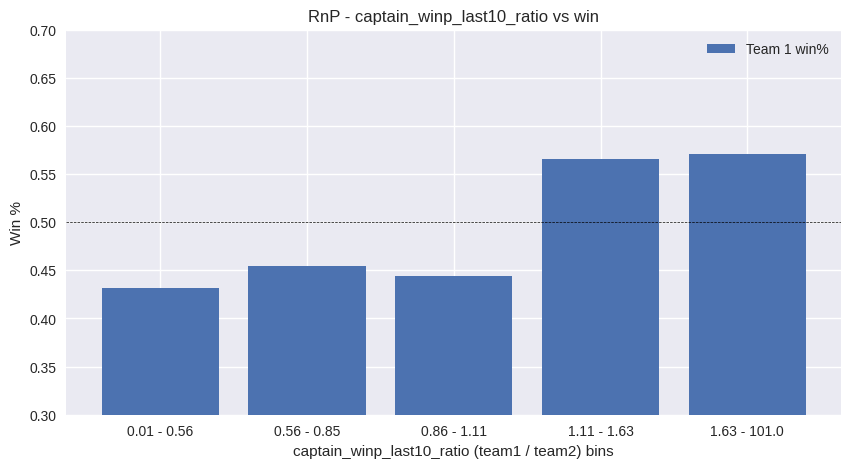

In [ ]:
#ratio of captain win percentage in last 10 matches
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

# Assuming the datasets are already loaded into these dataframes:
# batsman_df, bowler_df, match_df, train_data, test_data

# Define a function to calculate the win percentage for captains in their last 20 games
# Function to find the captain's ID for a given match and team
def find_captain(match_id, team_id):
    # Check batsmen first
    batsman_captain = batsman_df[(batsman_df['match id'] == match_id) & (batsman_df['is_batsman_captain'] == 1)]
    if not batsman_captain.empty and team_id in batsman_captain['team_id'].values:
        return batsman_captain[batsman_captain['team_id'] == team_id]['batsman_id'].values[0]

    # Check bowlers
    bowler_captain = bowler_df[(bowler_df['match id'] == match_id) & (bowler_df['is_bowler_captain'] == 1)]
    if not bowler_captain.empty and team_id in bowler_captain['team_id'].values:
        return bowler_captain[bowler_captain['team_id'] == team_id]['bowler_id'].values[0]

    return np.nan  # If no captain found

# Define a function to calculate the win percentage for captains in their last n games
def captain_win_percentage(team_id, date, n=10):
    recent_matches = match_df[(match_df['match_dt'] < date) &
                              ((match_df['team1_id'] == team_id) | (match_df['team2_id'] == team_id))]\
                              .sort_values(by='match_dt', ascending=False).head(1)
    if recent_matches.empty:
        return 50.00  # Default value or np.nan if no recent matches

    last_match_id = recent_matches['match id'].iloc[0]
    captain_id = find_captain(last_match_id, team_id)
    if pd.isna(captain_id):
        return 50.00  # Default value or np.nan if no captain found

    captain_matches = match_df[((match_df['team1_id'] == team_id) | (match_df['team2_id'] == team_id)) &
                               ((match_df['team1_captain_id'] == captain_id) | (match_df['team2_captain_id'] == captain_id))]
    relevant_captain_matches = captain_matches[captain_matches['match_dt'] < date].sort_values(by='match_dt', ascending=False).head(n)
    win_count = relevant_captain_matches[relevant_captain_matches['winner_id'] == team_id].shape[0]
    if relevant_captain_matches.shape[0] == 0:
        return 50.00
    return round(win_count * 100 / relevant_captain_matches.shape[0], 2)

# Add the captain's win percentage features to the train data
train_data['team1_captain_winp_last10'] = train_data.apply(lambda x:
                                    captain_win_percentage(x['team1_id'], x['match_dt'], 20), axis=1)
train_data['team2_captain_winp_last10'] = train_data.apply(lambda x:
                                    captain_win_percentage(x['team2_id'], x['match_dt'], 20), axis=1)

# Calculate the ratio of captain win percentages for both teams and add to the dataset
train_data['captain_winp_last10_ratio'] = (train_data['team1_captain_winp_last10'] + 1) / (train_data['team2_captain_winp_last10'] + 1)

# Drop intermediate columns
train_data.drop(columns=['team1_captain_winp_last10', 'team2_captain_winp_last10'], inplace=True)

# Perform similar operations for the test data
test_data['team1_captain_winp_last10'] = test_data.apply(lambda x:
                                    captain_win_percentage(x['team1_id'], x['match_dt'], 20), axis=1)
test_data['team2_captain_winp_last10'] = test_data.apply(lambda x:
                                    captain_win_percentage(x['team2_id'], x['match_dt'], 20), axis=1)
test_data['captain_winp_last10_ratio'] = (test_data['team1_captain_winp_last10'] + 1) / (test_data['team2_captain_winp_last10'] + 1)
test_data.drop(columns=['team1_captain_winp_last10', 'team2_captain_winp_last10'], inplace=True)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Updated Train Data with Captain Win Percentage", dataframe=train_data.head())
#tools.display_dataframe_to_user(name="Updated Test Data with Captain Win Percentage", dataframe=test_data.head())

train_data.head(), test_data.head()

createRnP(train_data , 'captain_winp_last10_ratio')

100%|██████████| 948/948 [00:47<00:00, 19.94it/s]


(948, 62)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,toss_winner_01,toss_decision_01,team1_top5_batsmen_ratio,team2_top5_batsmen_ratio,top5_batsmen_ratio,team1_batting_average,team2_batting_average,team1_bowling_average,team2_bowling_average,team1_balls_faced,team2_balls_faced,team1_runs_scored,team2_runs_scored,runs_ratio,runs_diff,batting_first_team,win_percentage_batting_first_ground,win_percentage_batting_second_ground,round_weighted_win_percentage,team1_win_batting_first,team1_win_bowling_first,team2_win_batting_first,team2_win_bowling_first,ground_weighted_win_percentage,all_rounder_ratio,all_rounder_diff,team1_toss_win_percentage,team2_toss_win_percentage,team1_win_percentage_after_winning_toss,team2_win_percentage_after_winning_toss,team1_win_percentage_after_losing_toss,team2_win_percentage_after_losing_toss,x1,x2,y1,y2,toss_factor_win_percentage,captain_winp_last10_ratio
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,night match,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1,0,1,0.789203,0.649593,1.214920,1.404332,1.419835,0.047458,0.052448,120.0,120.0,168.519856,170.380165,0.989081,-1.860310,30428,0.0,0.2,0.0,0.5,0.5,0.3,0.3,0.0,0.5,-2,0.448276,0.642857,0.384615,0.277778,0.5625,0.400000,0.384615,0.277778,0.5625,0.400000,0.961538,1.000000
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,day/night match,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1,1,0,0.906948,0.742760,1.221051,1.495362,1.241015,0.065336,0.052101,120.0,120.0,179.443414,148.921776,1.204951,30.521638,7727,0.0,0.0,0.0,0.7,0.9,0.3,0.4,0.0,1.0,0,0.483871,0.458333,0.733333,0.454545,0.5625,0.384615,0.733333,0.454545,0.5625,0.384615,1.237500,1.392157


slope: 0.6 / 0.39 =  1.53


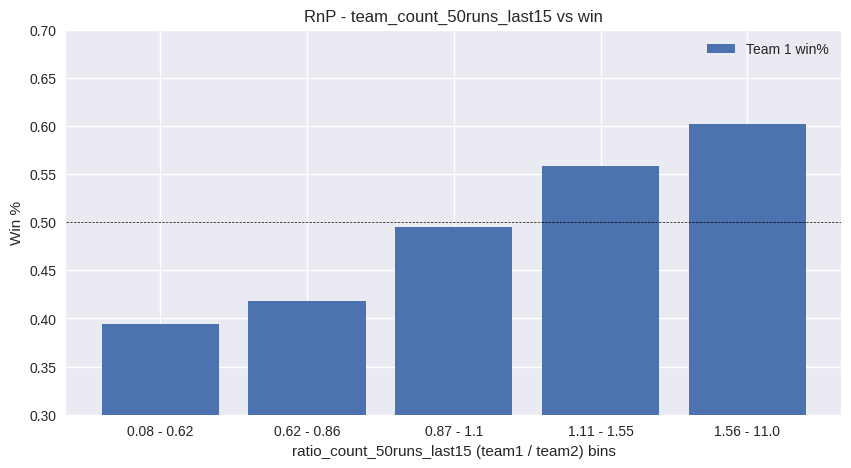

100%|██████████| 207/207 [00:10<00:00, 18.90it/s]


(207, 59)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,toss_winner_01,toss_decision_01,team1_top5_batsmen_ratio,team2_top5_batsmen_ratio,top5_batsmen_ratio,team1_batting_average,team2_batting_average,team1_bowling_average,team2_bowling_average,team1_balls_faced,team2_balls_faced,team1_runs_scored,team2_runs_scored,runs_ratio,runs_diff,batting_first_team,win_percentage_batting_first_ground,win_percentage_batting_second_ground,round_weighted_win_percentage,team1_win_batting_first,team1_win_bowling_first,team2_win_batting_first,team2_win_bowling_first,ground_weighted_win_percentage,all_rounder_ratio,all_rounder_diff,team1_toss_win_percentage,team2_toss_win_percentage,team1_win_percentage_after_winning_toss,team2_win_percentage_after_winning_toss,team1_win_percentage_after_losing_toss,team2_win_percentage_after_losing_toss,x1,x2,y1,y2,toss_factor_win_percentage,captain_winp_last10_ratio
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,1,0,0.850433,0.839713,1.012766,1.346090,1.568480,0.058431,0.048128,120,120.0,161.530782,188.217636,0.858213,-26.686854,33949,0.2,0.0,0.2,0.3,0.5,0.3,0.4,0.185714,0.5,-2,0.384615,0.555556,0.2,0.400000,0.5625,0.416667,0.2,0.400000,0.5625,0.416667,1.40625,1.000000
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,1,0,0.756522,0.755525,1.001319,0.966387,1.338262,0.027972,0.054795,120,120.0,115.966387,160.591497,0.722120,-44.625111,209,0.0,0.0,0.0,0.2,0.4,0.5,0.7,0.000000,1.0,0,0.555556,0.593750,0.8,0.473684,0.0000,0.384615,0.8,0.473684,0.0000,0.384615,0.00000,0.987826


In [ ]:
#Sample features
#Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games

def no50sLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.

    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.

    Output-None

    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_50runs']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.

# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_50runs_last15'] = (train_data['team1_count_50runs_last15']+1)/(train_data['team2_count_50runs_last15']+1)
train_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns

train_data.shape
train_data.tail(2)

# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_count_50runs_last15')

## Doing similar process for test dataset
test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_50runs_last15'] = (test_data['team1_count_50runs_last15'])/(test_data['team2_count_50runs_last15']+1)
test_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True)
test_data.shape
test_data.head(2)




100%|██████████| 948/948 [00:02<00:00, 412.44it/s]


(948, 62)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,toss_winner_01,toss_decision_01,team1_top5_batsmen_ratio,team2_top5_batsmen_ratio,top5_batsmen_ratio,team1_batting_average,team2_batting_average,team1_bowling_average,team2_bowling_average,team1_balls_faced,team2_balls_faced,team1_runs_scored,team2_runs_scored,runs_ratio,runs_diff,batting_first_team,win_percentage_batting_first_ground,win_percentage_batting_second_ground,round_weighted_win_percentage,team1_win_batting_first,team1_win_bowling_first,team2_win_batting_first,team2_win_bowling_first,ground_weighted_win_percentage,all_rounder_ratio,all_rounder_diff,team1_toss_win_percentage,team2_toss_win_percentage,team1_win_percentage_after_winning_toss,team2_win_percentage_after_winning_toss,team1_win_percentage_after_losing_toss,team2_win_percentage_after_losing_toss,x1,x2,y1,y2,toss_factor_win_percentage,captain_winp_last10_ratio
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,1,0,1.000000,1.000000,1.000000,1.006061,1.177305,0.045894,0.058333,120.0,120.0,120.727273,141.276596,0.854545,-20.549323,11283,0.0,0.0,0.0,0.5,0.666667,0.6,1.0,0.0,1.0,0,0.277778,0.181818,0.6,1.0,0.538462,0.555556,0.6,1.0,0.538462,0.555556,0.538462,0.788985
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0,1,0,0.830243,0.730874,1.135958,1.272232,1.264249,0.043706,0.045694,120.0,120.0,152.667877,151.709845,1.006315,0.958032,20,0.0,0.0,0.0,0.6,0.600000,0.5,0.6,0.0,0.4,-3,0.444444,0.434783,0.5,0.4,0.700000,0.461538,0.5,0.4,0.700000,0.461538,1.750000,1.162354


100%|██████████| 207/207 [00:00<00:00, 401.15it/s]


(207, 59)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,toss_winner_01,toss_decision_01,team1_top5_batsmen_ratio,team2_top5_batsmen_ratio,top5_batsmen_ratio,team1_batting_average,team2_batting_average,team1_bowling_average,team2_bowling_average,team1_balls_faced,team2_balls_faced,team1_runs_scored,team2_runs_scored,runs_ratio,runs_diff,batting_first_team,win_percentage_batting_first_ground,win_percentage_batting_second_ground,round_weighted_win_percentage,team1_win_batting_first,team1_win_bowling_first,team2_win_batting_first,team2_win_bowling_first,ground_weighted_win_percentage,all_rounder_ratio,all_rounder_diff,team1_toss_win_percentage,team2_toss_win_percentage,team1_win_percentage_after_winning_toss,team2_win_percentage_after_winning_toss,team1_win_percentage_after_losing_toss,team2_win_percentage_after_losing_toss,x1,x2,y1,y2,toss_factor_win_percentage,captain_winp_last10_ratio
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,1,0,0.850433,0.839713,1.012766,1.346090,1.568480,0.058431,0.048128,120,120.0,161.530782,188.217636,0.858213,-26.686854,33949,0.2,0.0,0.2,0.3,0.5,0.3,0.4,0.185714,0.5,-2,0.384615,0.555556,0.2,0.400000,0.5625,0.416667,0.2,0.400000,0.5625,0.416667,1.40625,1.000000
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,1,0,0.756522,0.755525,1.001319,0.966387,1.338262,0.027972,0.054795,120,120.0,115.966387,160.591497,0.722120,-44.625111,209,0.0,0.0,0.0,0.2,0.4,0.5,0.7,0.000000,1.0,0,0.555556,0.593750,0.8,0.473684,0.0000,0.384615,0.8,0.473684,0.0000,0.384615,0.00000,0.987826


slope: 0.58 / 0.4 =  1.47


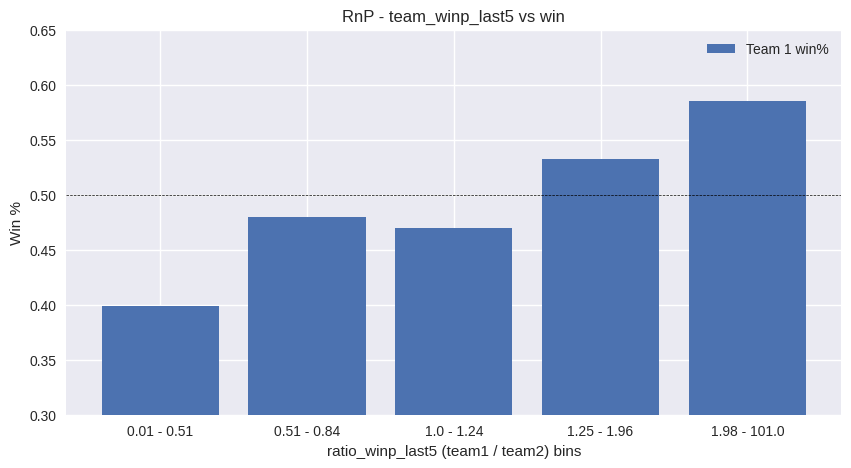

In [ ]:
#Sample feature 2
#Ratio of team1's win % to team2's win % in last 5 games

def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.

    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.

    Output- None

    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

# Compute team1's win% in last 5 games
train_data['team1_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 5), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 5), axis=1)

# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_winp_last5'] = (train_data['team1_winp_last5']+1)/(train_data['team2_winp_last5']+1)
train_data.drop(columns=['team1_winp_last5', 'team2_winp_last5'], inplace=True) # drop intermediate columns

train_data.shape
train_data.head(2)

## Similar process for test data
test_data['team1_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team1_id'], date=x['match_dt'], n= 5), axis=1)
test_data['team2_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team2_id'], date=x['match_dt'], n =5 ), axis=1)
test_data['team_winp_last5'] = (test_data['team1_winp_last5']+1)/(test_data['team2_winp_last5']+1)
test_data.drop(columns=['team1_winp_last5','team2_winp_last5'], inplace=True)
test_data.shape
test_data.head(2)

# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_winp_last5', ylim_ub=0.65)

#train_data.drop(columns=['winner_01'], inplace=True)
# Dropping intermediate column made to plot RnP.

In [ ]:
#Sample Feature 3
#Team1's average inning runs in the last 15 games

## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)

match_lvl_data.head(2)

def teamAvgRunsLastn(team_id, date, n):
    '''
    Function to calculate a team's average runs in their last n games.

    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.

    Output- None

    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean() # return mean of the combined dataframe.

# Compute average runs scored by team1 in their last 15 games for train data.
train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)

# Similarly for test data.
test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
            teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
test_data.shape
test_data.head(2)

train_data.shape
train_data.head(2)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id,captains,team1_captain_id,team2_captain_id,team1_bat_inning
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN,{17982: 258649.0},258649.0,NaN,1
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0,"{33942: 37351.0, 33963: 36665.0}",37351.0,36665.0,1


100%|██████████| 207/207 [00:01<00:00, 180.85it/s]


(207, 59)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,toss_winner_01,toss_decision_01,team1_top5_batsmen_ratio,team2_top5_batsmen_ratio,top5_batsmen_ratio,team1_batting_average,team2_batting_average,team1_bowling_average,team2_bowling_average,team1_balls_faced,team2_balls_faced,team1_runs_scored,team2_runs_scored,runs_ratio,runs_diff,batting_first_team,win_percentage_batting_first_ground,win_percentage_batting_second_ground,round_weighted_win_percentage,team1_win_batting_first,team1_win_bowling_first,team2_win_batting_first,team2_win_bowling_first,ground_weighted_win_percentage,all_rounder_ratio,all_rounder_diff,team1_toss_win_percentage,team2_toss_win_percentage,team1_win_percentage_after_winning_toss,team2_win_percentage_after_winning_toss,team1_win_percentage_after_losing_toss,team2_win_percentage_after_losing_toss,x1,x2,y1,y2,toss_factor_win_percentage,captain_winp_last10_ratio
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385,1,0,0.850433,0.839713,1.012766,1.346090,1.568480,0.058431,0.048128,120,120.0,161.530782,188.217636,0.858213,-26.686854,33949,0.2,0.0,0.2,0.3,0.5,0.3,0.4,0.185714,0.5,-2,0.384615,0.555556,0.2,0.400000,0.5625,0.416667,0.2,0.400000,0.5625,0.416667,1.40625,1.000000
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333,1,0,0.756522,0.755525,1.001319,0.966387,1.338262,0.027972,0.054795,120,120.0,115.966387,160.591497,0.722120,-44.625111,209,0.0,0.0,0.0,0.2,0.4,0.5,0.7,0.000000,1.0,0,0.555556,0.593750,0.8,0.473684,0.0000,0.384615,0.8,0.473684,0.0000,0.384615,0.00000,0.987826


(948, 62)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,toss_winner_01,toss_decision_01,team1_top5_batsmen_ratio,team2_top5_batsmen_ratio,top5_batsmen_ratio,team1_batting_average,team2_batting_average,team1_bowling_average,team2_bowling_average,team1_balls_faced,team2_balls_faced,team1_runs_scored,team2_runs_scored,runs_ratio,runs_diff,batting_first_team,win_percentage_batting_first_ground,win_percentage_batting_second_ground,round_weighted_win_percentage,team1_win_batting_first,team1_win_bowling_first,team2_win_batting_first,team2_win_bowling_first,ground_weighted_win_percentage,all_rounder_ratio,all_rounder_diff,team1_toss_win_percentage,team2_toss_win_percentage,team1_win_percentage_after_winning_toss,team2_win_percentage_after_winning_toss,team1_win_percentage_after_losing_toss,team2_win_percentage_after_losing_toss,x1,x2,y1,y2,toss_factor_win_percentage,captain_winp_last10_ratio
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,1,0,1.000000,1.000000,1.000000,1.006061,1.177305,0.045894,0.058333,120.0,120.0,120.727273,141.276596,0.854545,-20.549323,11283,0.0,0.0,0.0,0.5,0.666667,0.6,1.0,0.0,1.0,0,0.277778,0.181818,0.6,1.0,0.538462,0.555556,0.6,1.0,0.538462,0.555556,0.538462,0.788985
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,0,1,0,0.830243,0.730874,1.135958,1.272232,1.264249,0.043706,0.045694,120.0,120.0,152.667877,151.709845,1.006315,0.958032,20,0.0,0.0,0.0,0.6,0.600000,0.5,0.6,0.0,0.4,-3,0.444444,0.434783,0.5,0.4,0.700000,0.461538,0.5,0.4,0.700000,0.461538,1.750000,1.162354


In [ ]:
#Sample feature 4
#Team1's win percentage against Team2 in the last 15 games

def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.

    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.

    Output- None

    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.

# Compute team1 win% against team2 in their past 15 encounters for train data.
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 15), axis=1)

train_data.shape
train_data.head(2)

# Similarly for test data.
test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 15), axis=1)

test_data.shape
test_data.head(2)


100%|██████████| 948/948 [00:04<00:00, 211.37it/s]


(948, 40)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,toss_winner_01,toss_decision_01,batting_first_team,win_percentage_batting_first_ground,all_rounder_ratio,diff,team1_toss_win_percentage,team2_toss_win_percentage,team1_win_percentage_after_winning_toss,team2_win_percentage_after_winning_toss,team1_win_percentage_after_losing_toss,team2_win_percentage_after_losing_toss,x1,x2,y1,y2,weighted_win_percentage
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,0,11283,0.0,1.0,0,0.277778,0.181818,0.6,1.0,0.538462,0.555556,0.166667,0.181818,0.401235,0.440559,0.912471
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,1,0,20,0.0,1.0,0,0.444444,0.434783,0.5,0.4,0.700000,0.461538,0.222222,0.173913,0.256410,0.395652,0.840347


100%|██████████| 271/271 [00:00<00:00, 349.69it/s]


(271, 25)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,toss_winner_01,toss_decision_01,batting_first_team,win_percentage_batting_first_ground
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,1,0,28594,0.0
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5,1,0,36084,0.0


In [ ]:
#sample feature 5
#Average runs scored in the ground in the last 15 games

def avgRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.

    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.

    Output- None

    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&(match_lvl_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.

train_data.shape
train_data.head(2)

test_data.shape
test_data.head(2)

(948, 40)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,toss_winner_01,toss_decision_01,batting_first_team,win_percentage_batting_first_ground,all_rounder_ratio,diff,team1_toss_win_percentage,team2_toss_win_percentage,team1_win_percentage_after_winning_toss,team2_win_percentage_after_winning_toss,team1_win_percentage_after_losing_toss,team2_win_percentage_after_losing_toss,x1,x2,y1,y2,weighted_win_percentage
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571,1,0,11283,0.0,1.0,0,0.277778,0.181818,0.6,1.0,0.538462,0.555556,0.166667,0.181818,0.401235,0.440559,0.912471
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000,1,0,20,0.0,1.0,0,0.444444,0.434783,0.5,0.4,0.700000,0.461538,0.222222,0.173913,0.256410,0.395652,0.840347


(271, 25)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,toss_winner_01,toss_decision_01,batting_first_team,win_percentage_batting_first_ground
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,day match,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN,1,0,28594,0.0
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,night match,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5,1,0,36084,0.0


In [ ]:
train_data.to_csv('train_data_with_samplefeatures', index=False)
test_data.to_csv('test_data_with_samplefeatures', index=False)


In [ ]:
#Cheatsheet 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
## Load libraries
import pandas as pd
import numpy as np
# Display options
pd.set_option('display.max_columns',50)
#train_data = pd.read_csv('/content/train_data_with_samplefeatures')
#test_data = pd.read_csv('/content/test_data_with_samplefeatures')

X,y = train_data[['top5_batsmen_ratio', 'runs_diff','all_rounder_diff' , 'toss_factor_win_percentage', 'team_count_50runs_last15' , 'team_winp_last5']], train_data['winner_01']
#'team_winp_last5'
X_test = test_data[X.columns.tolist()]

X_nans = X.isna().sum().reset_index()
X_nans[X_nans[0]!=0]

X_test_nans = X_test.isna().sum().reset_index()
X_test_nans[X_test_nans[0]!=0]

X.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

X_nans = X.isna().sum().reset_index()
X_nans[X_nans[0]!=0]

X_test_nans = X_test.isna().sum().reset_index()
X_test_nans[X_test_nans[0]!=0]

#X['toss_winner_01'].value_counts()
#X['toss_decision_01'].value_counts()
#X['team_count_50runs_last15'].describe()

from sklearn.ensemble import GradientBoostingClassifier

# user-defined parameters

# user-defined parameters

algo_name = 'GradientBoostingClassifier'
is_ensemble = 'no'
n_trees = 10
depth = 2
lr = 0.1


clf_gbm = GradientBoostingClassifier(n_estimators = n_trees, max_depth = depth, learning_rate = lr).fit(X,y)
train_data['y_pred_01'] = clf_gbm.predict(X)
test_data['y_pred_01'] = clf_gbm.predict(X_test)

from sklearn.metrics import classification_report
# Train accuracy
print(classification_report(y, clf_gbm.predict(X), labels=[0,1]))
train_data['win_pred_score'] = clf_gbm.predict_proba(X)[:,1]
test_data['win_pred_score'] = clf_gbm.predict_proba(X_test)[:,1]

train_data['win_pred_score'] = np.where( (train_data['y_pred_01']==0), (1-train_data['win_pred_score']), train_data['win_pred_score'])
test_data['win_pred_score'] = np.where( (test_data['y_pred_01']==0), (1-test_data['win_pred_score']), test_data['win_pred_score'])

train_data['win_pred_team_id'] = np.where( (train_data['y_pred_01']==0), (train_data['team1_id']), train_data['team2_id'])
test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])

df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train':clf_gbm.feature_importances_}).sort_values(by='model_feat_imp_train', ascending=False)\
                                                                                                                        .reset_index(drop=True).head(10)
df_feat_importance

train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r2'

## refactor

df_file1 = pd.concat([test_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]])
# \train_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]])

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

feature_desc = {'top5_batsmen_ratio':'Ratio of percentage runs scored by first 5 batsman',\
                'runs_diff':'Difference of the expected runs scored by both the teams',\
                'all_rounder_diff':'difference of number of All rounders',\
                'toss_factor_win_percentage': 'If team 1 win toss -  team 1 win percent after winning toss / team 2 win percentage after losing toss else If team 2 win toss - team 1 win percent after losing toss / team 2 win percentage after winning toss',\
                'team_winp_last5' : 'Ratio of team1 win percent to team2s win percent in last 5 games' ,\
                'team_count_50runs_last15' : 'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games' ,\
                }
# 'ground_weighted_win_percentage': 'Percentage teams winning when batting first on the given ground (if team 1 is batting first) else Percentage teams winning when batting second on the given ground',\


# df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)

df_file1.to_csv('file1.csv', index=False)
df_file2.to_csv('file2.csv')


,index,0
0,top5_batsmen_ratio,35


,index,0
0,top5_batsmen_ratio,1


<ipython-input-16-afa5115f2b14>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)
<ipython-input-16-afa5115f2b14>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(0, inplace=True)


,index,0


,index,0


              precision    recall  f1-score   support

           0       0.60      0.60      0.60       468
           1       0.61      0.60      0.61       480

    accuracy                           0.60       948
   macro avg       0.60      0.60      0.60       948
weighted avg       0.60      0.60      0.60       948



,feat_name,model_feat_imp_train
0,team_count_50runs_last15,0.402687
1,toss_factor_win_percentage,0.234097
2,top5_batsmen_ratio,0.168835
3,runs_diff,0.089917
4,all_rounder_diff,0.079536
5,team_winp_last5,0.024927


In [ ]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Display options
pd.set_option('display.max_columns', 50)


# Create binary target variable
train_data['winner_01'] = train_data.apply(lambda x: 1 if (x['team2'] == x['winner']) else 0, axis=1)

# Toss winner to numerical - 1 if team2 wins, else 0
train_data['toss_winner_01'] = np.where(train_data['toss winner'] == train_data['team2'], 1, 0)
test_data['toss_winner_01'] = np.where(test_data['toss winner'] == test_data['team2'], 1, 0)

# Toss decision - categorical - 1 if winner bats, 0 otherwise
train_data['toss_decision_01'] = np.where(train_data['toss decision'] == 'bat', 1, 0)
test_data['toss_decision_01'] = np.where(test_data['toss decision'] == 'bat', 1, 0)

# Feature columns
feature_columns = ['top5_batsmen_ratio', 'runs_diff','all_rounder_diff' , 'toss_factor_win_percentage','captain_winp_last10_ratio', 'team_count_50runs_last15' , 'team_winp_last5']


X = train_data[feature_columns]
y = train_data['winner_01']
X_test = test_data[feature_columns]

# Check for missing values
X = X.fillna(0)
X_test = X_test.fillna(0)

# Split train data into training and validation sets (90% train, 10% test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the model parameters
algo_name = 'GradientBoostingClassifier'
is_ensemble = 'no'
n_trees = 10
depth = 2
lr = 0.1

# Train the model
clf_gbm = GradientBoostingClassifier(n_estimators=n_trees, max_depth=depth, learning_rate=lr).fit(X_train, y_train)

# Predict on training and validation data
train_preds = clf_gbm.predict(X_train)
val_pred = clf_gbm.predict(X_val)
test_preds = clf_gbm.predict(X_test)

# Evaluate the model on the validation set
print("Validation Set Classification Report:")
print(classification_report(y_val, val_pred, labels=[0, 1]))

# Add prediction probabilities
train_pred_scores = clf_gbm.predict_proba(X_train)[:, 1]
test_pred_scores = clf_gbm.predict_proba(X_test)[:, 1]

# Assign predictions and probabilities to the original train and test data
train_data['y_pred_01'] = np.nan
train_data.loc[X_train.index, 'y_pred_01'] = train_preds

train_data['win_pred_score'] = np.nan
train_data.loc[X_train.index, 'win_pred_score'] = train_pred_scores

train_data['win_pred_score'] = np.where((train_data['y_pred_01'] == 0), (1 - train_data['win_pred_score']), train_data['win_pred_score'])
train_data['win_pred_team_id'] = np.where((train_data['y_pred_01'] == 0), (train_data['team1_id']), (train_data['team2_id']))

test_data['y_pred_01'] = test_preds
test_data['win_pred_score'] = test_pred_scores
test_data['win_pred_score'] = np.where((test_data['y_pred_01'] == 0), (1 - test_data['win_pred_score']), test_data['win_pred_score'])
test_data['win_pred_team_id'] = np.where((test_data['y_pred_01'] == 0), (test_data['team1_id']), (test_data['team2_id']))

# Feature importance
df_feat_importance = pd.DataFrame({'feat_name': X.columns.tolist(), 'model_feat_imp_train': clf_gbm.feature_importances_}) \
    .sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)

# Combine train and test data for output
train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r1'

df_file1 = pd.concat([test_data[['match id', 'dataset_type', 'win_pred_team_id', 'win_pred_score'] + list(df_feat_importance['feat_name'].head(10))],
                      train_data[['match id', 'dataset_type', 'win_pred_team_id', 'win_pred_score'] + list(df_feat_importance['feat_name'].head(10))]])

# Rename columns
renaming_dict = {col: f'indep_feat_id{i+1}' for i, col in enumerate(list(df_feat_importance['feat_name'].head(10)))}
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1, 11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

# Feature description
feature_desc = {'top5_batsman_ratio':'Ratio of percentage runs scored by first 5 batsman',\
                'runs_diff':'Difference of the expected runs scored by both the teams',\
                'all_rounder_ratio':'difference of number of All rounders',\
                'ground_weighted_win_percentage': 'Percentage teams winning when batting first on the given ground (if team 1 is batting first) else Percentage teams winning when batting second on the given ground',\
                'toss_factor_win_percentage': 'If team 1 win toss -  team 1 win percent after winning toss / team 2 win percentage after losing toss else If team 2 win toss - team 1 win percent after losing toss / team 2 win percentage after winning toss',\
                'captain_winp_last20_ratio': 'Ratio of captain win percentage in last 10 matches',\
                'team_winp_last5' : 'Ratio of team1 win percent to team2s win percent in last 5 games' ,\
                'team_count_50runs_last15' : 'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games' ,\
                }

# Feature importance DataFrame
df_file2 = df_feat_importance
df_file2['feat_id'] = [i + 1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i + 1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)


KeyError: "['top5_batsmen_ratio', 'runs_diff', 'ground_weighted_win_percentage', 'all_rounder_diff', 'toss_factor_win_percentage', 'captain_winp_last10_ratio'] not in index"

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Feature columns
feature_columns = ['top5_batsmen_ratio', 'runs_diff','all_rounder_diff' , 'toss_factor_win_percentage','captain_winp_last10_ratio', 'team_count_50runs_last15' , 'team_winp_last5']


X = train_data[feature_columns]
y = train_data['winner_01']
X_test = test_data[feature_columns]

# Check for missing values
X = X.fillna(0)
X_test = X_test.fillna(0)

# Split train data into training and validation sets (90% train, 10% test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
# Train the final model with best parameters
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'reg_alpha': [0, 0.01, 0.1], 'reg_lambda': [1, 1.5, 2],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.9}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.5368


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Load datasets
file1_path = '/content/file1.csv'
file2_path = '/content/train_data_with_samplefeatures.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Filter training data
train_data = df1[df1['dataset_type'] == 'train']

# Merge to get the winner_id
train_data = train_data.merge(df2[['match id', 'winner_id']], on='match id')

# Select features and target
features = ['indep_feat_id1', 'indep_feat_id2', 'indep_feat_id3', 'indep_feat_id4', 'indep_feat_id5', 'indep_feat_id6', 'indep_feat_id7']
X = train_data[features]
y = train_data['winner_id']

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grids
param_grids = {
    'GBM': {
        'clf__learning_rate': [0.01, 0.1, 0.05],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'clf__learning_rate': [0.01, 0.1, 0.05],
        'clf__n_estimators': [100, 200, 300],
        'clf__num_leaves': [31, 40, 50]
    },
    'XGBoost': {
        'clf__learning_rate': [0.01, 0.1, 0.05],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7]
    },
    'CatBoost': {
        'clf__learning_rate': [0.01, 0.1, 0.05],
        'clf__iterations': [100, 200, 300],
        'clf__depth': [3, 5, 7]
    }
}

# Initialize classifiers
classifiers = {
    'GBM': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Function to perform GridSearchCV and print best parameters and accuracy
def tune_and_evaluate(model_name, model, param_grid):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Validation Accuracy: {accuracy}")

# Tune and evaluate each model
for model_name in classifiers:
    print(f"--- Tuning {model_name} ---")
    tune_and_evaluate(model_name, classifiers[model_name], param_grids[model_name])

--- Tuning GBM ---
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
#accuracy test

import pandas as pd
import sys


# Instructions for participants :
'''
Participants can use this code to run on labeled train/out-of-sample data to mimic evaluation process.
### Datasets required:
This script takes in 3 files as follows:

primary_submission.csv -> This contains the match_id, dataset_type, win_pred_team_id, win_pred_score, train_algorithm, is_ensemble, train_hps_trees, train_hps_depth, train_hps_lr, *top 10 feature values. This is file submitted by participant.
secondary_submission.csv -> This contains feature_name, feature_description, model_feature_importance_rank, model_feature_importance_percentage, feature_correlation_dep_var. This is file submitted by participant.
dep_var.csv    -> This contains match_id, dataset_type, win_team_id. Participants can generate from the labeled train data.

Please ensure that the predicted_score column does not have any null columns and the column names are exactly matching as above.
Please ensure that all these files are stored as ',' separated csv files.

### How to use:
To use this, first open the command line terminal, and call evaluation code script by passing the locations of submission and actual files respectively.
Sample example of using commandline for running the script:

python Evaluation_Code.py path_to_primary_submission_file path_to_secondary_submission_file path_to_DepVar_file
'''


def checkDataType1(df):
    assert (df['match id'].isna().sum() == 0), 'match id should not have NaNs'
    assert (df['match id'].dtype == 'int64'), ('match id is not int64 type')
    assert df['win_pred_team_id'].isna().sum(
    ) == 0, 'win_pred_team_id should not have NaNs'
    assert df['win_pred_team_id'].dtype == 'int64', (
        'win_pred_team_id is not int64 type')
    assert df['win_pred_score'].isna().sum(
    ) == 0, 'win_pred_score should not have NaNs'
    assert df['win_pred_score'].dtype == 'float64', (
        'win_pred_score is not float64 type')
    assert df['train_algorithm'].isna().sum(
    ) == 0, 'train_algorithm should not have NaNs'
    assert df['train_algorithm'].dtype == 'object', (
        'train_algorithm is not object type')
    assert df['is_ensemble'].isna().sum(
    ) == 0, 'is_ensemble should not have NaNs'
    assert df['is_ensemble'].dtype == 'object', (
        'is_ensemble is not object type')
    assert df['train_hps_trees'].isna().sum(
    ) == 0, 'train_hps_trees should not have NaNs'
    assert df['train_hps_depth'].isna().sum(
    ) == 0, 'train_hps_depth should not have NaNs'
    assert df['train_hps_lr'].isna().sum(
    ) == 0, 'train_hps_lr should not have NaNs'
    return None


def checkDataType2(df):
    assert df['feat_id'].isna().sum() == 0, 'feat_id should not have NaNs'
    assert df['feat_id'].dtype == 'int64', ('feat_id is not int type')
    assert df['feat_name'].isna().sum() == 0, 'feat_name should not have NaNs'
    assert df['feat_name'].dtype == 'object', ('feat_name is not object type')
    assert df['feat_description'].isna().sum(
    ) == 0, 'feat_description should not have NaNs'
    assert df['feat_description'].dtype == 'object', (
        'feat_description is not object type')
    assert df['model_feat_imp_train'].isna().sum(
    ) == 0, ' model_feat_imp_train should not have NaNs'
    assert df['model_feat_imp_train'].dtype == 'float64', (
        'model_feat_imp_train is not float type')
    assert df['feat_rank_train'].isna().sum(
    ) == 0, 'feat_rank_train should not have NaNs'
    assert df['feat_rank_train'].dtype == 'int64', (
        'feat_rank_train is not int64 type')
    return None


def getAccuracy(df):
    return round(df[df['winner_id_y'] == df['win_pred_team_id']].shape[0]*100/df.shape[0], 4)


# Location of submission file. Header here should include match_id, dataset_type, win_team_id. The file should be comma separated.

df_input1 = pd.read_csv('/content/file1.csv', sep=",", header=0)


df_input2 = pd.read_csv('/content/file2.csv', sep=",", header=0)

# For participants Team : Location of Dependent Variable file. Header here would be match_id, dataset_type, win_team_id. Participants can generate from the labeled train data. These files are comma separated
df_round = pd.read_csv('/content/file3_updated.csv', sep=",", header=0)

assert set(['match id', 'dataset_type', 'win_pred_team_id', 'win_pred_score', 'train_algorithm', 'is_ensemble', 'train_hps_trees','train_hps_depth', 'train_hps_lr']).issubset(set(df_input1.columns.tolist())), 'Required columns not present in primary submission file'
assert set(['indep_feat_id1', 'indep_feat_id2', 'indep_feat_id3', 'indep_feat_id4', 'indep_feat_id5', 'indep_feat_id6', 'indep_feat_id7', 'indep_feat_id8', 'indep_feat_id9', 'indep_feat_id10']).issubset(set(df_input1.columns.tolist())), 'Required indepedent feature columns not present in primary submission file'
assert set(['feat_id', 'feat_name', 'feat_description', 'model_feat_imp_train', 'feat_rank_train']).issubset(set(df_input2.columns.tolist())), 'Required columns not present in secondary submission file'

checkDataType1(df_input1)
checkDataType2(df_input2)

assert df_input1.shape[0] == df_input1.drop_duplicates('match id').shape[0], 'Input file should be unique on match id'
# assert df_input1.shape[
#     0] == 1219, f'Input file size number of rows incorrect. Expected rowsize 1219 not equal to uploaded data rowsize {df_input1.shape[0]}'
assert df_input1.shape[1] == 19, 'Input file number of columns not correct. '
assert (df_input1.win_pred_score.min() >= 0) & (df_input1.win_pred_score.max() <= 1), 'Win prediction score should be in range [0,1]'
assert df_input1['train_algorithm'].nunique() == 1, 'only one algorithm can be used for all data'
assert (len(df_input1['is_ensemble'].unique().tolist()) == 1) & ((df_input1['is_ensemble'].unique().tolist()[0] == 'yes') | (df_input1['is_ensemble'].unique().tolist()[0] == 'no')), 'is_ensemble can take only \'yes\' or \'no\''
assert df_input1.apply(lambda x: 0 if (len(str(x['train_algorithm']).split(';')) == len(str(x['train_hps_trees']).split(';'))) &(len(str(x['train_algorithm']).split(';')) == len(str(x['train_hps_depth']).split(';'))) & (len(str(x['train_algorithm']).split(';')) == len(str(x['train_hps_lr']).split(';'))) else 1, axis=1).max() == 0, 'number of fields in algorithm & hyper-parameters column should be same.'

'''
shape_before_join = df_round.shape[0]

r1_size = df_input1[df_input1['dataset_type'] == 'r1'].shape[0]
assert (r1_size ==
        df_round.shape[0]), f'R1 data size in input file is incorrect. Expected rowsize 271 not equal to r1 dataset_type present {r1_size}'
'''

# merging predicted file and dependent variable file
eval_data = pd.merge(df_round, df_input1, on=['match id'], how='inner').drop_duplicates()
assert (eval_data.shape[0] == df_round.shape[0]), 'match ids in submission template does not match eval data'

print('All checks passed...')
print('Accuracy: ', round(getAccuracy(eval_data), 2))


"\nParticipants can use this code to run on labeled train/out-of-sample data to mimic evaluation process.\n### Datasets required:\nThis script takes in 3 files as follows:\n\nprimary_submission.csv -> This contains the match_id, dataset_type, win_pred_team_id, win_pred_score, train_algorithm, is_ensemble, train_hps_trees, train_hps_depth, train_hps_lr, *top 10 feature values. This is file submitted by participant.\nsecondary_submission.csv -> This contains feature_name, feature_description, model_feature_importance_rank, model_feature_importance_percentage, feature_correlation_dep_var. This is file submitted by participant.\ndep_var.csv    -> This contains match_id, dataset_type, win_team_id. Participants can generate from the labeled train data.\n\nPlease ensure that the predicted_score column does not have any null columns and the column names are exactly matching as above.\nPlease ensure that all these files are stored as ',' separated csv files.\n\n### How to use:\nTo use this, fir

"\nshape_before_join = df_round.shape[0]\n\nr1_size = df_input1[df_input1['dataset_type'] == 'r1'].shape[0]\nassert (r1_size ==\n        df_round.shape[0]), f'R1 data size in input file is incorrect. Expected rowsize 271 not equal to r1 dataset_type present {r1_size}'\n"

All checks passed...
Accuracy:  46.27
